In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,confusion_matrix, classification_report, roc_curve, auc, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# Load dataset
df = pd.read_csv('../data/processed_with_features.csv')
print(f"Loaded data: {df.shape}")
df.head()
print(df.columns.tolist())

Loaded data: (15000, 149)
['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_i

/var/folders/1n/k2rpq0810dl2zgrrw3bk2tlw0000gn/T/ipykernel_13774/1354571593.py:2: DtypeWarning: Columns (123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/processed_with_features.csv')


In [30]:
# Define Feature Lists
numerical_features = [
    'sentiment_score',
    'readability_score',
    'income_to_loan',
    'loan_amnt',
    'installment',
    'annual_inc',
    'dti'
]

categorical_features = [
    'emp_length',
    'home_ownership',
    'purpose',
    'term'
]

target = 'loan_status_binary'

In [31]:
# Clean & Encode
df = df[numerical_features + categorical_features + [target]].dropna()
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Sanitize column names to fix XGBoost error
df_encoded.columns = df_encoded.columns.str.replace('[\[\]<>()]', '_', regex=True)

<>:6: SyntaxWarning: invalid escape sequence '\['
<>:6: SyntaxWarning: invalid escape sequence '\['
/var/folders/1n/k2rpq0810dl2zgrrw3bk2tlw0000gn/T/ipykernel_13774/1721536259.py:6: SyntaxWarning: invalid escape sequence '\['
  df_encoded.columns = df_encoded.columns.str.replace('[\[\]<>()]', '_', regex=True)


In [32]:
# Define X and y
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

In [33]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [34]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 01 Logistic Regression

In [36]:
print("Logistic Regression")

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score:{f1_score(y_test, y_pred_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
ROC-AUC: 0.6571
Accuracy: 0.6361
F1 Score:0.4978

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      1921
           1       0.46      0.54      0.50       951

    accuracy                           0.64      2872
   macro avg       0.60      0.61      0.61      2872
weighted avg       0.65      0.64      0.64      2872



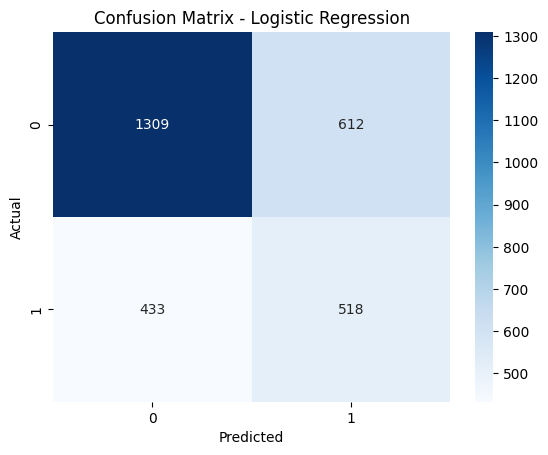

In [25]:
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [26]:
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_lr)
roc_auc_base = auc(fpr_base, tpr_base)

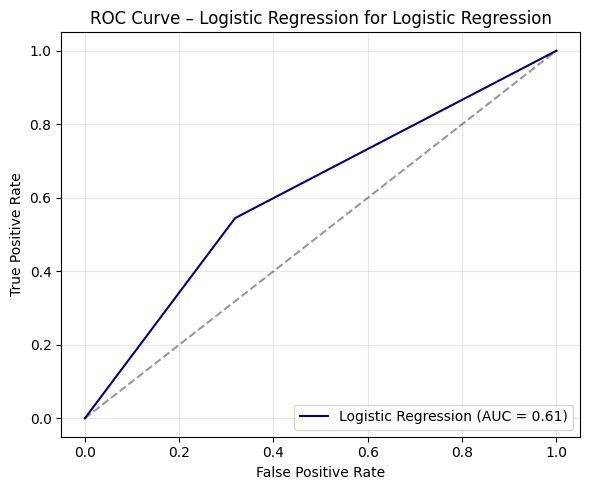

In [27]:
# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr_base, tpr_base, label=f"Logistic Regression (AUC = {roc_auc_base:.2f})", color='navy')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)
plt.title("ROC Curve – Logistic Regression for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 02 Random Forest

In [37]:
print("Random Forest")

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score:{f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest
ROC-AUC: 0.6227
Accuracy: 0.6685
F1 Score:0.2562

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.79      1921
           1       0.50      0.17      0.26       951

    accuracy                           0.67      2872
   macro avg       0.59      0.54      0.52      2872
weighted avg       0.63      0.67      0.61      2872



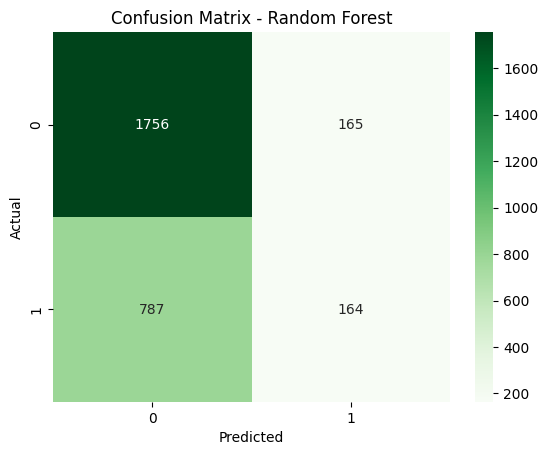

In [33]:
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 03 XGBoost

In [27]:
print("XGBoost")

xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=2.0)

xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost
ROC-AUC: 0.6203
Accuracy: 0.6194

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1921
           1       0.43      0.45      0.44       951

    accuracy                           0.62      2872
   macro avg       0.58      0.58      0.58      2872
weighted avg       0.62      0.62      0.62      2872



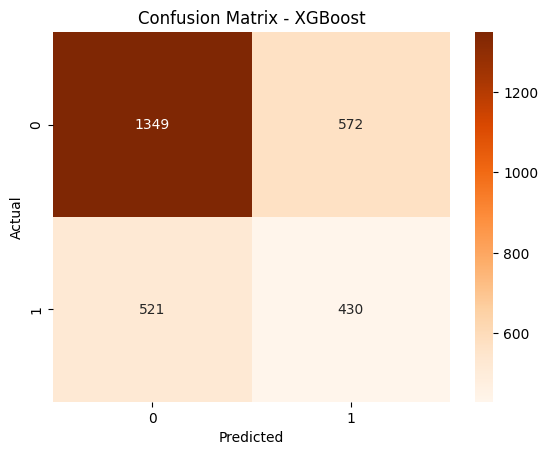

In [34]:
cm = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()